In [4]:
from torch.utils.data import DataLoader
from tonic import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np

from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_HIDDEN_NEURONS, NUMBER_HIDDEN_LAYERS, NUMBER_OUTPUT_NEURONS, BETA, TIME_STEPS, BATCH_SIZE, DEVICE

In [5]:
import copy

untrained_model = ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS, 
                                               number_output_neurons=NUMBER_OUTPUT_NEURONS, 
                                               number_hidden_layers=NUMBER_HIDDEN_LAYERS,
                                               number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                               sparsity=0,
                                               beta=BETA, 
                                               time_steps=TIME_STEPS)

trained_model = copy.deepcopy(untrained_model)
trained_model.load_state_dict(torch.load('./models/best_sparsity.pth'))

<All keys matched successfully>

In [6]:
frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

In [7]:
data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(DEVICE)

In [8]:
selection_index = 0

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]

hidden_spk_rec_untrained, _, output_spk_rec_untrained, _ = untrained_model(data)

x_hidden_untrained_selected = hidden_spk_rec_untrained[:, selection_index, :]
x_output_untrained_selected = output_spk_rec_untrained[:, selection_index, :]

hidden_spk_rec_trained, _, output_spk_rec_trained, _ = trained_model(data)

x_hidden_trained_selected = hidden_spk_rec_trained[:, selection_index, :]
x_output_trained_selected = output_spk_rec_trained[:, selection_index, :]

ValueError: not enough values to unpack (expected 4, got 2)

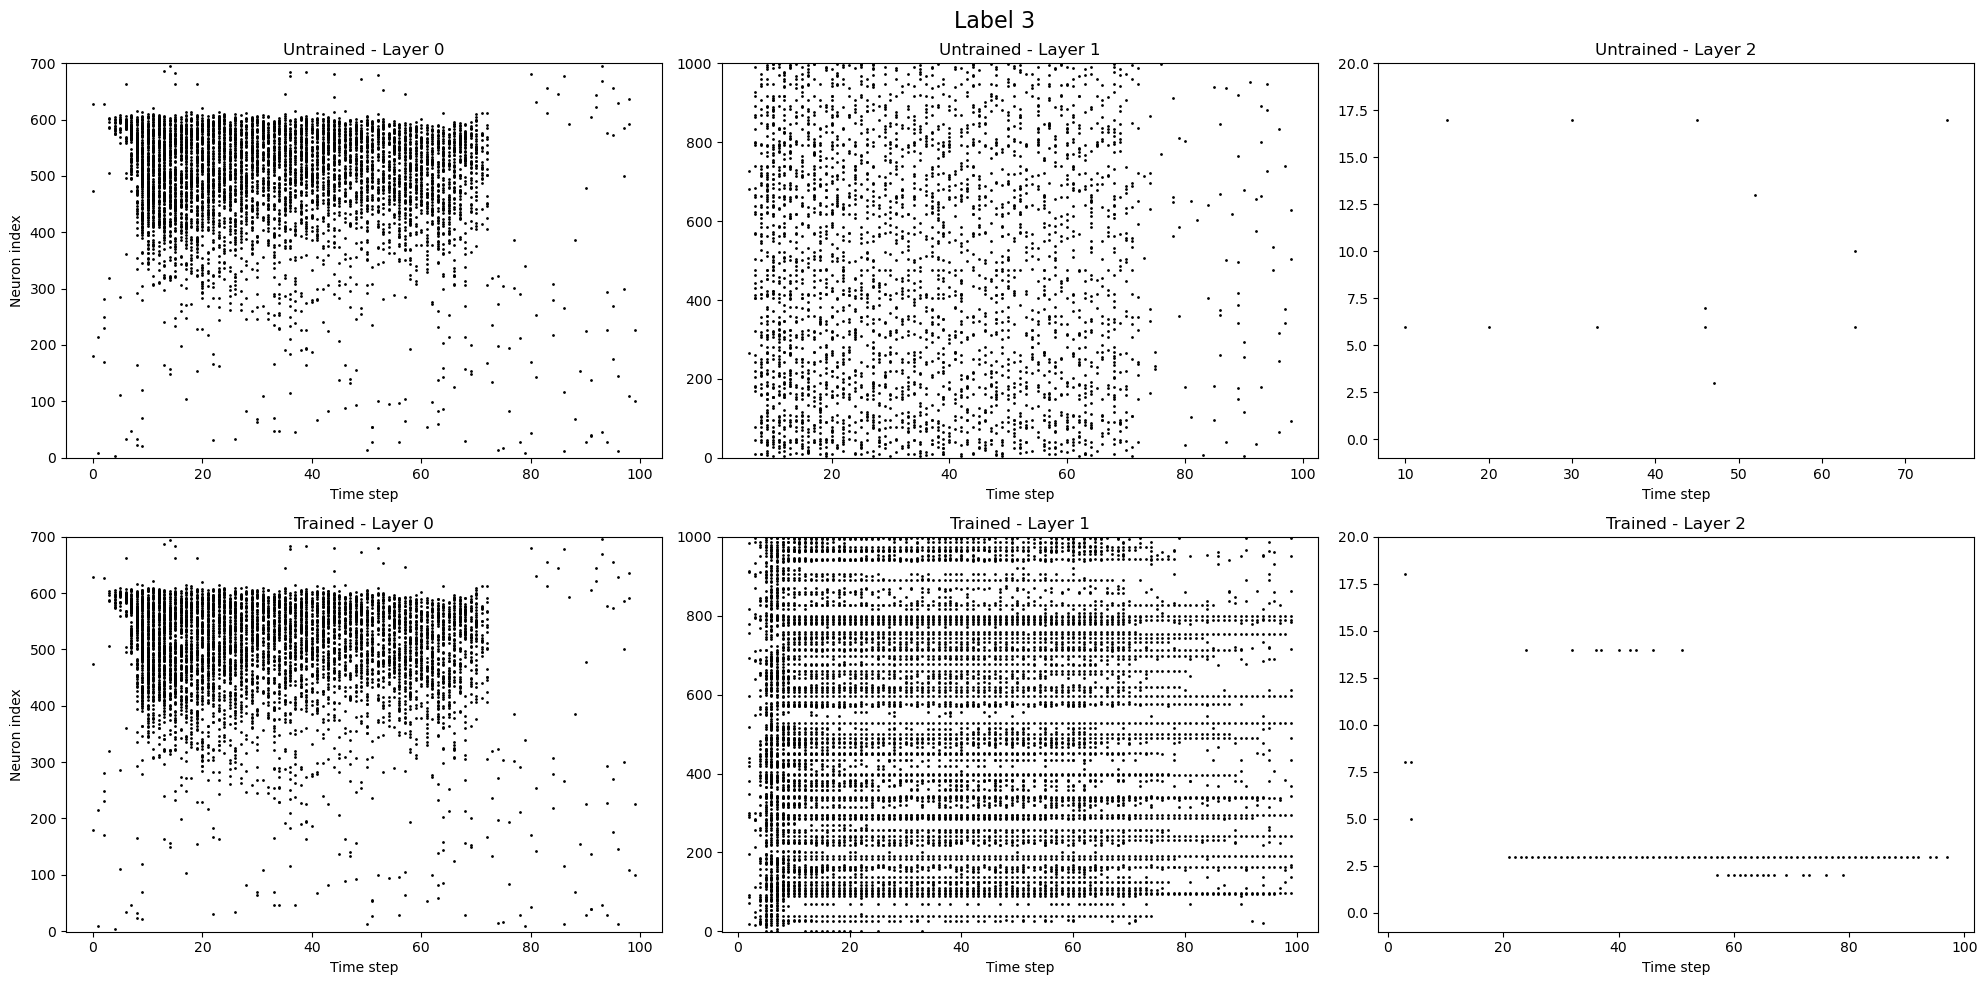

In [ ]:
# TODO: needs adjustment, see best configurations evaluation

spike_matrices_untrained = [x_selected, x_hidden_untrained_selected.detach(), x_output_untrained_selected.detach()]
spike_matrices_trained = [x_selected, x_hidden_trained_selected.detach(), x_output_trained_selected.detach()]

# 2 rows (untrained on top, trained on bottom), 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

fig.suptitle(f"Label {y_selected}", fontsize=16)

for index in range(3):
    # Untrained plot (top row)
    spike_matrix_np = spike_matrices_untrained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_untrained = axes[0, index]
    ax_untrained.scatter(times, neurons, s=1, color='black')
    ax_untrained.set_title(f"Untrained - Layer {index}")
    ax_untrained.set_xlabel("Time step")
    ax_untrained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_untrained.set_ylabel("Neuron index")

    # Trained plot (bottom row)
    spike_matrix_np = spike_matrices_trained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_trained = axes[1, index]
    ax_trained.scatter(times, neurons, s=1, color='black')
    ax_trained.set_title(f"Trained - Layer {index}")
    ax_trained.set_xlabel("Time step")
    ax_trained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_trained.set_ylabel("Neuron index")

plt.tight_layout()
plt.show()
